# Модель прогнозирования стоимости жилья для агентства недвижимости - Часть 2

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import ast
import plotly.graph_objects as go
import pickle
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Функция для построения графиков 
def show_plot(col):
    plt.figure(figsize=(12,6))
    col.value_counts().plot(kind='bar')
    for i,val in enumerate(col.value_counts()):
        plt.text(i, val, int(val))
    plt.show()

# Разведывательный анализ данных

In [230]:
df = pd.read_csv('data/data_preproc.csv')
df.head()

status   propertyType  baths  fireplace    sqft  beds  stories  \
0    active  single-family    3.5          1  2900.0   4.0      1.0   
1  for sale  single-family    3.0          0  1947.0   3.0      2.0   
2  for sale  single-family    8.0          1  6457.0   5.0      3.0   
3  for sale      townhouse    3.0          0   897.0   2.0      2.0   
4    active          other    2.0          0  1507.0   3.0      1.0   

      target    ZIP        LAT  ...     heating  cooling          parking  \
0   418000.0  28387  35.179251  ...     central  no data          no data   
1   310000.0  99216  47.686363  ...     no data  no data          no data   
2  2395000.0  75205  32.835893  ...  forced air  central  detached garage   
3   209000.0  19145  39.909857  ...  forced air  central          no data   
4   181500.0  34759  28.103908  ...    electric  central          no data   

  lotsize remodeling lotsize_was_null  mean_school_rating  \
0  8276.0          0                1                 5.2   
1  5828.0          0                0                 4.0   
2  8220.0          1                0                 9.2   
3   680.0          0                0                 1.4   
4  4996.0          1                0                 2.3   

   mean_school_distance  schools_count  beds_was_null  
0                   5.5            8.0              0  
1                   1.3            3.0              0  
2                   0.8            4.0              0  
3                   0.4            2.0              0  
4                   3.8            4.0              1  

[5 rows x 23 columns]

In [231]:
# посмотрим на наши обработанные данные
profile = ProfileReport(df, title="ИНФОРМАЦИЯ ОБ ОБЪЕКТАХ НЕДВИЖИМОСТИ")
profile.to_file("preprocessed_data.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Проверим нашу целевую переменную

In [232]:
# проверим ассиметрию
print(df['target'].skew())

2.2659354287210074


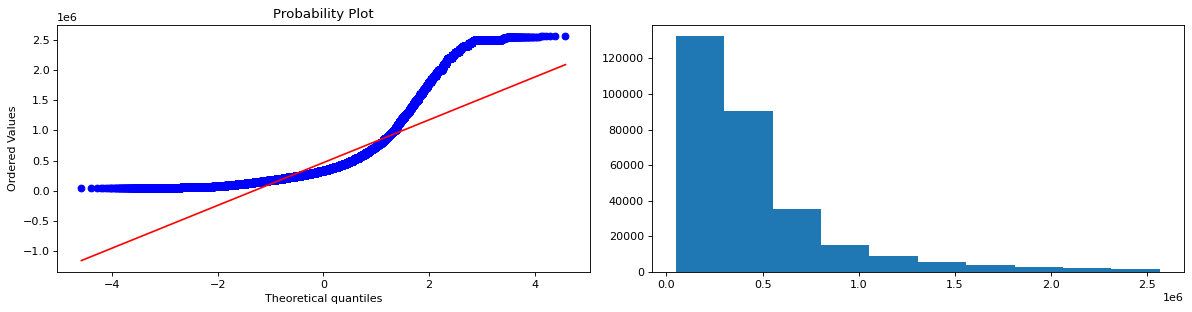

In [233]:
plt.figure(figsize=(15, 4), dpi=80)
plt.subplot(1, 2, 1)
stats.probplot(df['target'], plot=plt)

plt.subplot(1, 2, 2)
plt.hist(df['target'])

plt.tight_layout()
plt.show()

Судя по графику, наша целевая переменная не является нормально распределенной.

In [234]:
# тест Шапиро-Уилка
stats.shapiro(df['target'])

ShapiroResult(statistic=0.7578234992504793, pvalue=5.171832608362483e-163)

Статистика теста равна 0.757, а значение pvalue очень близко к 0. Поскольку p-значение меньше 0,05, мы отвергаем нулевую гипотезу. Значит данные не имеют нормального распределения.

Но такой тест хорошо работает только на выборке до 5000 объектов.

In [235]:
# тест Колмогорова-Смирнова
stats.kstest(df['target'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=48550.0, statistic_sign=-1)

Статистика теста равна 1, а значение pvalue=0.0. Это еще раз доказывает, что данные выборки НЕ распределены нормально.

In [236]:
df['target'].describe()

count    2.978270e+05
mean     4.664982e+05
std      4.069955e+05
min      4.855000e+04
25%      2.190000e+05
50%      3.350000e+05
75%      5.590000e+05
max      2.565000e+06
Name: target, dtype: float64

Итак: минимальная стоимость дома в наших данных составляет 48,5 тыс долларов, а максимальная - более 2.5 млн долларов. Средняя стоимость - 466 тыс. долларов, а медианная - 335 тыс. долларов.

Далее проверим различные взаимозависимости наших данных на графиках:

In [237]:
fig = px.scatter(
    data_frame = df.groupby(['year_built'], as_index=False)['target'].median(),
    y = 'target',   
    x = 'year_built',
    color = 'target',
    title = 'Распределение медианной стоимости объекта недвижимости в зависимости от даты постройки',       
    height = 500,    
    width = 1000      
)
fig.show()

Большой разброс медианных зачений стоимости жилья до 1900 года связан с небольшим количеством таких объявлений. Далее медианная стоимость меняется незначительно.

In [238]:
# проверим самые дорогие объекты
df[df.target > 2550000]

status   propertyType  baths  fireplace    sqft  beds  stories  \
50486   for sale   multi-family    4.0          0  1630.0   5.0      1.0   
90833   for sale  single-family    7.0          1  5000.0   5.0      1.0   
145875  for sale  single-family    6.5          0  6590.0   6.0      3.0   
245513  for sale          condo    3.0          0  2252.0   3.0      3.0   
258148  for sale  single-family    4.0          0  3444.0   3.0      2.0   
267905  for sale  single-family    5.0          0  3434.0   4.0      1.0   
278127  for sale  single-family    4.0          1  4018.0   3.0      2.0   

           target    ZIP        LAT  ...     heating  cooling  \
50486   2555000.0  90291  33.993396  ...        wall  no data   
90833   2565000.0  11375  40.720934  ...       other  central   
145875  2559990.0  92618  33.666942  ...     no data  no data   
245513  2559000.0  11231  40.677916  ...     no data  central   
258148  2560000.0  80304  40.045421  ...  forced air  central   
267905  2558000.0  94539  37.516907  ...  forced air  central   
278127  2559000.0  90049  34.092540  ...  forced air  central   

                parking   lotsize remodeling lotsize_was_null  \
50486         5+ spaces    5198.0          0                0   
90833   attached garage    5000.0          1                0   
145875          no data    8276.0          0                1   
245513          no data    4046.0          0                0   
258148  attached garage  125888.4          1                0   
267905  attached garage    6849.0          0                0   
278127         2 spaces  701751.6          1                0   

        mean_school_rating  mean_school_distance  schools_count  beds_was_null  
50486                  6.3                   0.7            3.0              0  
90833                  7.0                   1.1            3.0              0  
145875                 9.0                   3.0            3.0              0  
245513                 8.0                   0.1            1.0              0  
258148                 7.3                   2.7            3.0              0  
267905                 9.5                   1.4            3.0              0  
278127                 8.3                   3.8            3.0              0  

[7 rows x 23 columns]

In [239]:
fig = px.histogram(
    data_frame = df.groupby(['status'], as_index=False)['target'].count(),
    x = 'status',
    y = 'target',
    color ='status',
    height = 500, 
    width = 1000, 
    title = 'Распределение объектов в зависимости от статуса',
    text_auto = True   
)

fig.show()

В наших данных самая большая часть объявлений о продаже находится в статусе for sale - 197 тыс. На втором месте в статусе active - 75 тыс. Наименьшая группа auction - 1163 объявлений.

In [240]:
fig = px.bar(
    data_frame = df.groupby(['status'], as_index=False)['target'].median(),
    x ='status',
    y ='target',
    color ='status',
    text ='target', 
    orientation ='v',
    title ='Медианная стоимость в зависимости от статуса',
    height = 500, 
    width = 1000   
)

fig.show()

По медианной стоимости недвижимости видим, что наибольшая категория это новое жилье (new construction - 448 тыс $). На втором месте статус under contract showing.

In [241]:
fig = px.histogram(
    data_frame = df.groupby(['propertyType'], as_index=False)['target'].count().sort_values(by=['target'], ascending=False),
    x ='propertyType',
    y = 'target',
    color ='propertyType',
    height = 500, 
    width = 1000, 
    title = 'Распределение в зависимости от типа объекта надвижимости',
    text_auto = True   
)

fig.show()

Преимущественное большинство объявлений о продаже недвижимости - это продажа домов типа **single family**(для одной семьи).

In [242]:
fig = px.bar(
    data_frame= df.groupby(['propertyType'], as_index=False)['target'].median().sort_values(by=['target'], ascending=False),
    x = 'propertyType',
    y = 'target',
    color = 'propertyType',
    text = 'target', 
    orientation = 'v',
    title = 'Медианная стоимость в зависимости от типа объекта надвижимости',
    height = 500, 
    width = 1000   
)

fig.show()

In [243]:
fig = px.bar(
    data_frame = df.groupby(['propertyType'], as_index=False)['sqft'].median().sort_values(by=['sqft'], ascending=False),
    x = 'propertyType',
    y = 'sqft',
    color = 'propertyType',
    text = 'sqft', 
    orientation = 'v',
    title = 'Распределение медианной площади в зависимости от типа объекта',
    height = 500, 
    width = 1000   
)

fig.show()

In [244]:
fig = px.scatter(
    data_frame = df.groupby(['year_built'], as_index=False)['sqft'].median(),
    y = 'sqft',   
    x = 'year_built',
    color = 'sqft',
    title = 'Распределение медианной площади в зависимости от года постройки',       
    height = 500,    
    width = 1000       
)
fig.show()

In [245]:
fig = px.histogram(
    data_frame = df,
    x = 'mean_school_rating',    
    title = 'Распределение среднего рейтинга школ',
    text_auto = True,    
    height = 500,    
    width = 1000,
    nbins = 40     
)
fig.show()

Определим число уникальных значений во всех наших признаках

In [246]:
# создаём пустой список
unique_list = []
# пробегаемся по именам столбцов в таблице
for col in df.columns:
    # создаём кортеж (имя столбца, число уникальных значений)
    item = (col, df[col].nunique(),df[col].dtypes) 
    # добавляем кортеж в список
    unique_list.append(item) 
# создаём вспомогательную таблицу и сортируем её
unique_counts = pd.DataFrame(
    unique_list,
    columns=['Column_Name', 'Num_Unique', 'Type']
).sort_values(by='Num_Unique',  ignore_index=True)
# выводим её на экран
display(unique_counts)

Column_Name  Num_Unique     Type
0           private_pool           2    int64
1       lotsize_was_null           2    int64
2             remodeling           2    int64
3          beds_was_null           2    int64
4              fireplace           2    int64
5                 status           9   object
6           propertyType           9   object
7                cooling          10   object
8                heating          10   object
9                parking          15   object
10         schools_count          24  float64
11                  beds          28  float64
12                 baths          48  float64
13               stories          72  float64
14    mean_school_rating          87  float64
15            year_built         214    int64
16  mean_school_distance         271  float64
17                   LAT        4034  float64
18                   LNG        4034  float64
19                   ZIP        4057    int64
20                  sqft        7510  float64
21               lotsize       15406  float64
22                target       29549  float64

Построим матрицу корреляции для всех числовых признаков

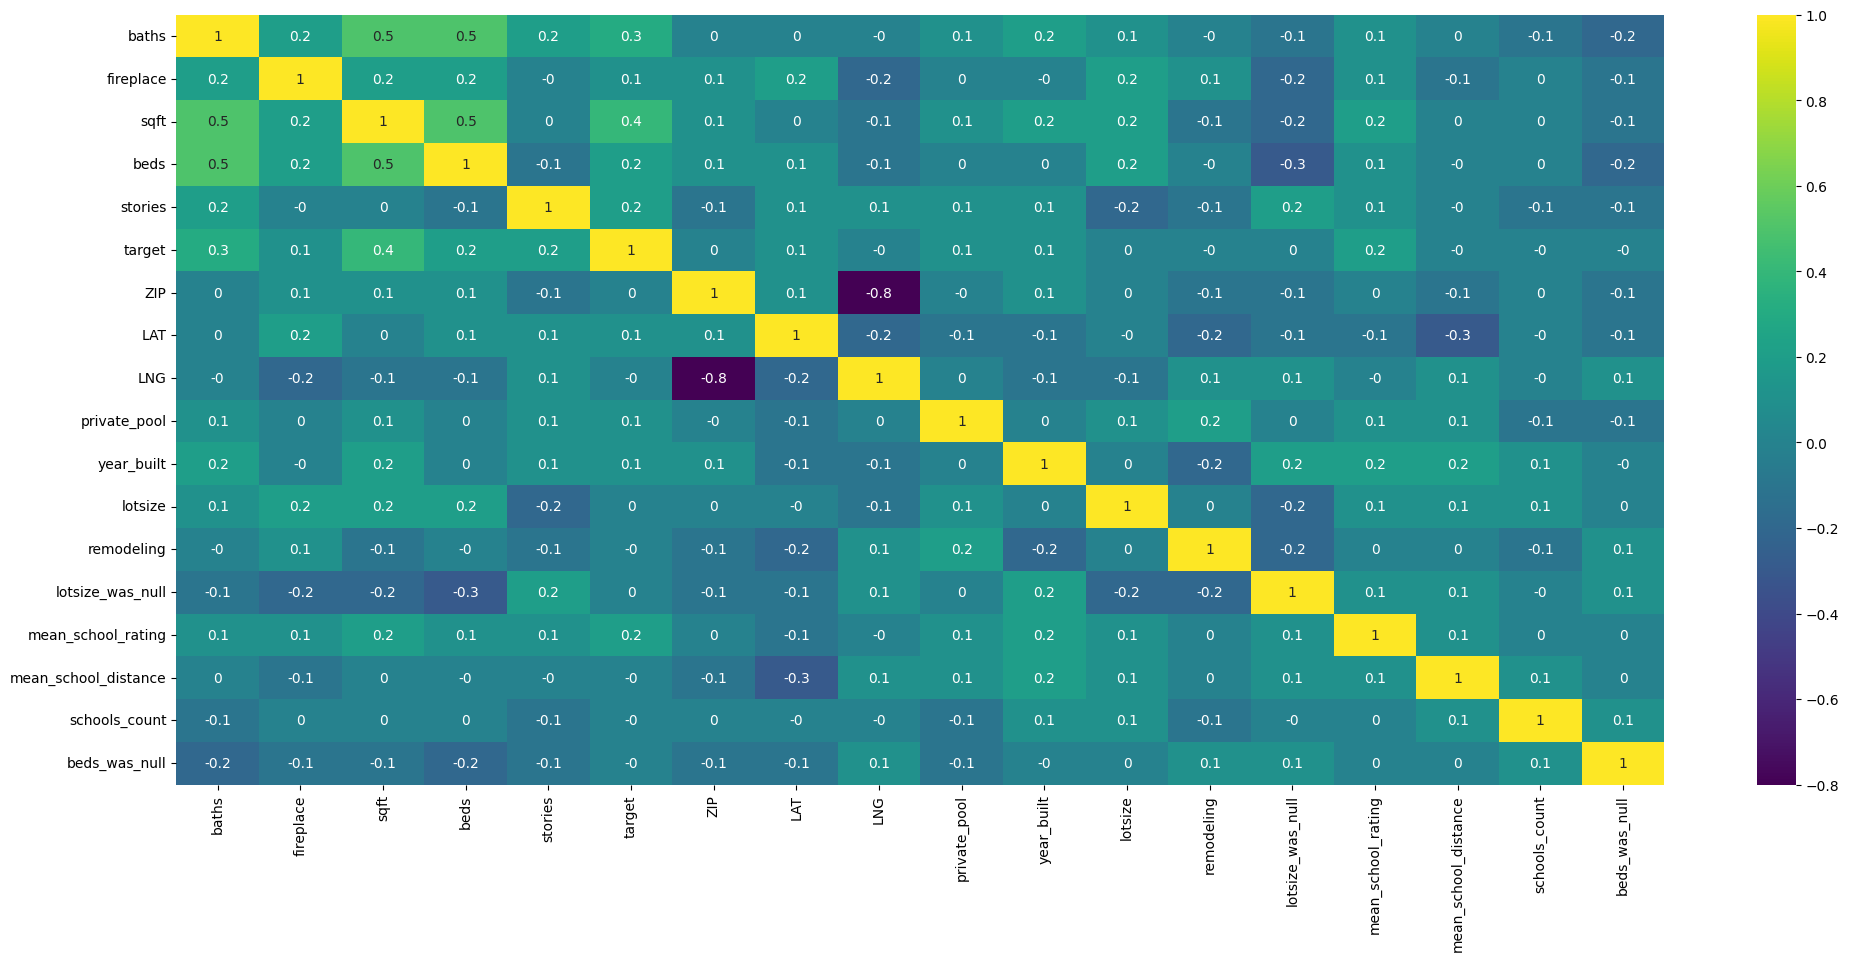

In [247]:
# строим матрицу корреляции
fig, axes = plt.subplots(figsize=(24, 10))
sns.heatmap(round(df.corr(method = 'kendall', numeric_only=True), 1), cmap = 'viridis', annot = True);

В нашем наборе данных есть 5 категориальных признаков, каждый из которых содержит от 9 до 15 уникальных значений. Применим для них OneHotEncoding. 

In [248]:
df = pd.get_dummies(df, columns=['status', 'propertyType', 'cooling', 'heating', 'parking'], drop_first=True)

Теперь когда мы избавились от категориальных признаков проверим корреляцию в наших данных

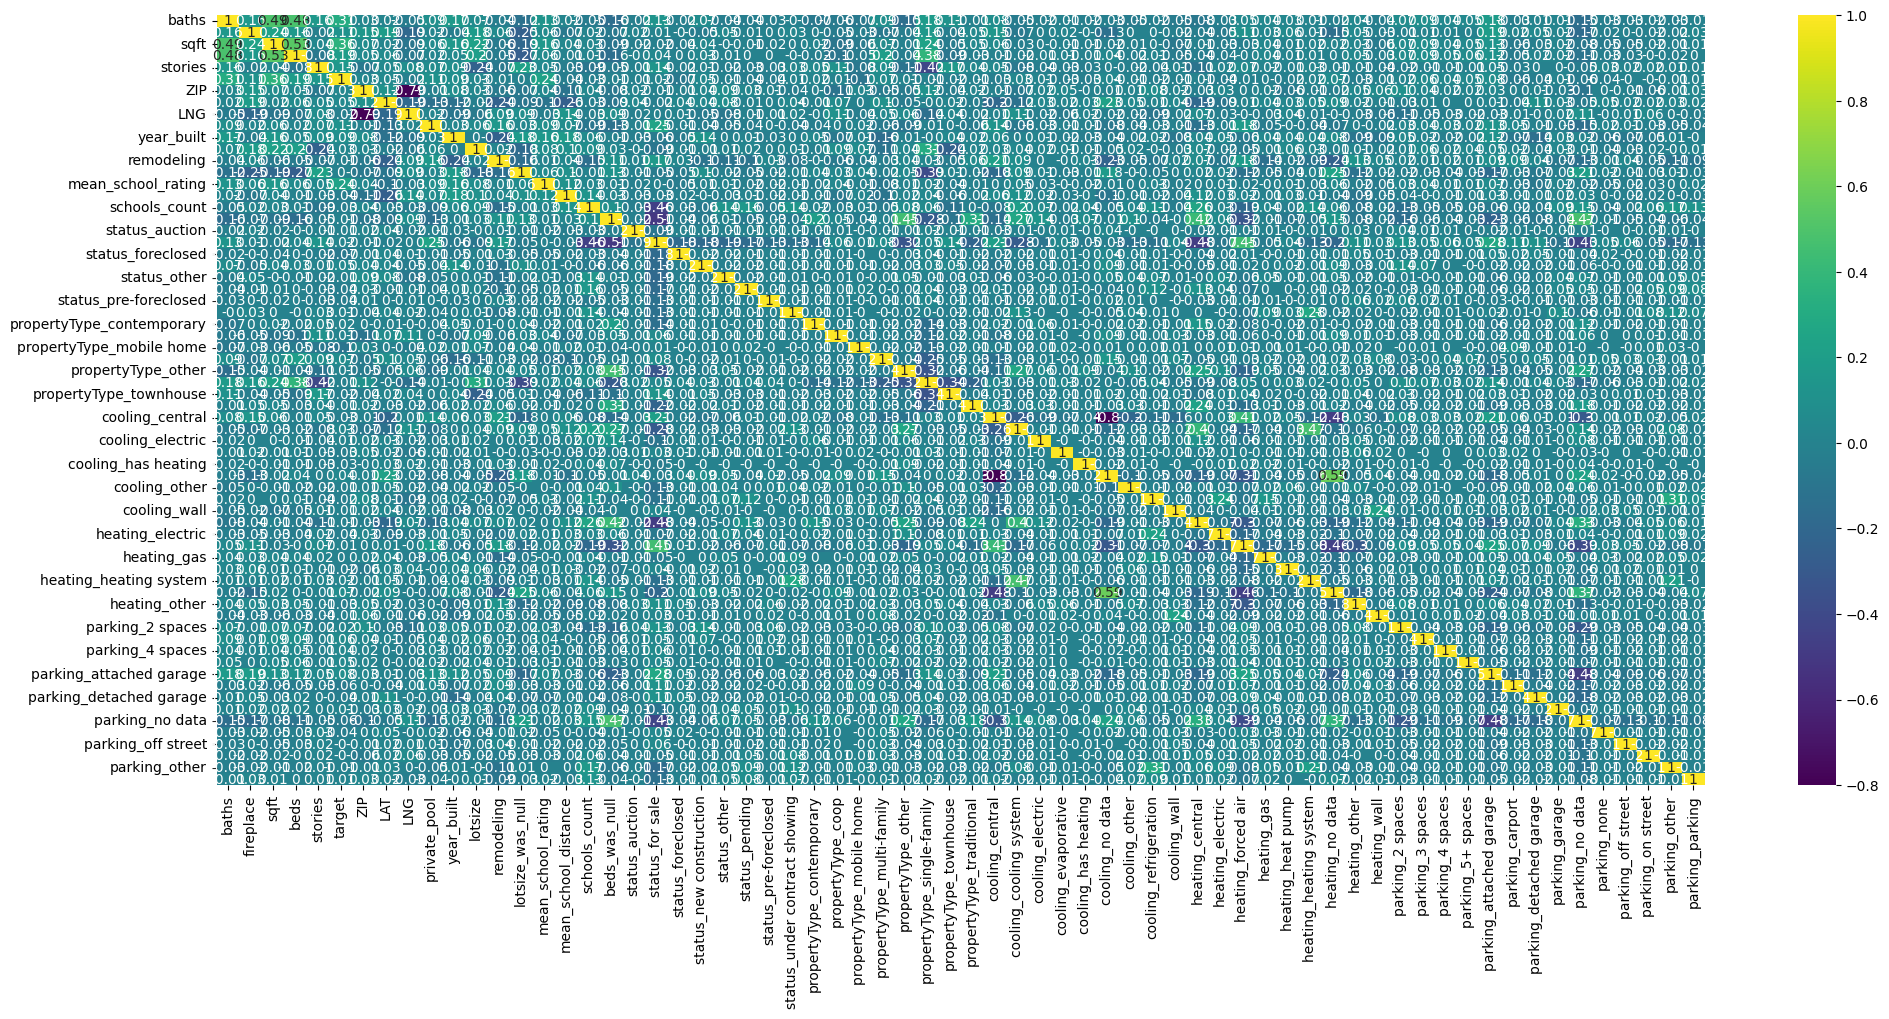

In [249]:
# строим матрицу корреляции и визализируем ее на теплограмме
fig, axes = plt.subplots(figsize=(24, 10))
sns.heatmap(round(df.corr(method = 'kendall'), 2), cmap = 'viridis', annot = True);

Видим очень сильную корреляцию у признаков ZIP и LNG, что очевидно, т.к. мы заполняли географические координаты исходя из zip-кода. Необходимо удалить один из признаков, предлагаю ZIP.\
Кроме этого наблюдается очень сильная корреляция у признаков cooling_central и cooling_no data. Избавимся от cooling_no data

In [250]:
# Удаляем сильно скореллированные признаки 
df.drop(['ZIP', 'cooling_no data'], axis = 1, inplace = True)
# Еще раз выгрузим данные для модели в csv
df.to_csv('data/data_4_model.csv', index = False)

In [251]:
df = pd.read_csv('data/data_4_model.csv')
df.head()

baths  fireplace    sqft  beds  stories     target        LAT         LNG  \
0    3.5          1  2900.0   4.0      1.0   418000.0  35.179251  -79.376489   
1    3.0          0  1947.0   3.0      2.0   310000.0  47.686363 -117.216681   
2    8.0          1  6457.0   5.0      3.0  2395000.0  32.835893  -96.795514   
3    3.0          0   897.0   2.0      2.0   209000.0  39.909857  -75.198265   
4    2.0          0  1507.0   3.0      1.0   181500.0  28.103908  -81.419378   

   private_pool  year_built  ...  parking_attached garage  parking_carport  \
0             0        2019  ...                    False            False   
1             0        2019  ...                    False            False   
2             0        2006  ...                    False            False   
3             0        1920  ...                    False            False   
4             0        2006  ...                    False            False   

   parking_detached garage  parking_garage  parking_no data  parking_none  \
0                    False           False             True         False   
1                    False           False             True         False   
2                     True           False            False         False   
3                    False           False             True         False   
4                    False           False             True         False   

   parking_off street  parking_on street  parking_other  parking_parking  
0               False              False          False            False  
1               False              False          False            False  
2               False              False          False            False  
3               False              False          False            False  
4               False              False          False            False  

[5 rows x 64 columns]

# Моделирование

Теперь, когда все наши признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы за исключением целевого признака target и его логарифмированной версии target_log:

In [252]:
X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

Нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помним, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

In [253]:
# инициализируем нормализатор MinMaxScaler
scaler = preprocessing.MinMaxScaler()

# обучаем скейлер на тренировочной выборке
scaler.fit(X_train)

# трансформируем тренировочные и тестовые данные 
X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
X_train_scal = pd.DataFrame(X_train_scal, columns=X_train.columns)
X_test_scal = pd.DataFrame(X_test_scal, columns=X_test.columns)

Cоздадим функцию, которая будет расчитывать метрики:

1. MAE - средняя абсолютная ошибка (целевая метрика)
2. MAPE - средняя абсолютная ошибка в процентах 
3. $R^2$ - коэффициент детерминации 

In [254]:
def print_metrics(model_name, y_train, y_train_predict, y_test, y_test_predict):
    train_r2 = metrics.r2_score(y_train, y_train_predict)
    train_mae = metrics.mean_absolute_error(y_train, y_train_predict)
    train_mape = metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100
    test_r2 = metrics.r2_score(y_test, y_test_predict)
    test_mae = metrics.mean_absolute_error(y_test, y_test_predict)
    test_mape = metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100
    print('Train R^2: {:.3f}'.format(train_r2))
    print('Train MAE: {:.3f}'.format(train_mae))
    print('Train MAPE: {:.3f}%'.format(train_mape))
    print('\n')
    print('Test R^2: {:.3f}'.format(test_r2))
    print('Test MAE: {:.3f}'.format(test_mae))
    print('Test MAPE: {:.3f}%'.format(test_mape))
    return [model_name, 
            round(train_r2, 2),
            round(train_mae, 2),
            round(train_mape, 2),
            round(test_r2, 2), 
            round(test_mae, 2), 
            round(test_mape, 2)
            ]

## Линейная регрессия

Первым делом сформируем базовую модель на всех признаках, после стандартизации их получилось 63. Далее производим предсказание на тренировочной и тестовых данных и считаем метрики.

In [255]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train_scal, y_train)
#Делаем предсказание для каждой из выборок
y_train_predict = lr.predict(X_train_scal)
y_test_predict = lr.predict(X_test_scal)
#Выводим результирующие метрики
s1 = print_metrics('LR full', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.423
Train MAE: 207802.911
Train MAPE: 61.458%


Test R^2: 0.416
Test MAE: 207015.899
Test MAPE: 61.946%


Базовая модель показала очень плохие результаты. Средняя абсолютная ошибка больше 200000$. Коэффициенты детерминации для тренировочной и тестовой выборок 0.423/0.416, что говорит нам о низком разбросе ответов модели для разных выборок. Возможно зависимость нелинейная.

Попробуем метод на основе фильтров. Обучим модель на 25 отобранных признаках - для этого используем SelectKBest.

In [256]:
selector = feature_selection.SelectKBest(feature_selection.f_regression, k=25)
selector.fit(X_train_scal, y_train)
best_features = selector.get_feature_names_out()
best_features

array(['baths', 'fireplace', 'sqft', 'beds', 'stories', 'LAT', 'LNG',
       'private_pool', 'lotsize', 'mean_school_rating', 'schools_count',
       'status_foreclosed', 'status_pending', 'status_pre-foreclosed',
       'propertyType_mobile home', 'propertyType_multi-family',
       'propertyType_single-family', 'heating_electric',
       'heating_no data', 'parking_3 spaces', 'parking_4 spaces',
       'parking_5+ spaces', 'parking_attached garage', 'parking_carport',
       'parking_no data'], dtype=object)

Построим модель линейной регрессии на топ-25 отобранных признаках.

In [257]:
lr_2 = LinearRegression()
lr_2.fit(X_train_scal[best_features], y_train)
y_train_predict = lr_2.predict(X_train_scal[best_features])
y_test_predict = lr_2.predict(X_test_scal[best_features])

s2 = print_metrics('LR top25', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.380
Train MAE: 215438.114
Train MAPE: 61.305%


Test R^2: 0.374
Test MAE: 214632.645
Test MAPE: 61.693%


Метрики лучше не стали. Попробуем полиномиальную регрессию

## Полиномиальная регрессия

In [258]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scal[best_features])
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train_scal[best_features])
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test_scal[best_features])

print(X_train_poly.shape)
print(X_test_poly.shape)
print('\n')

#Создаём объект класса линейной регрессии
lr_model_poly = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model_poly.fit(X_train_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict = lr_model_poly.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_test_predict = lr_model_poly.predict(X_test_poly)

s3 = print_metrics('PR top25', y_train, y_train_predict, y_test, y_test_predict)

(238261, 350)
(59566, 350)


Train R^2: 0.522
Train MAE: 186266.086
Train MAPE: 51.861%


Test R^2: 0.511
Test MAE: 186139.564
Test MAPE: 52.253%


Метрики улучшились, но такая модель по прежнему малопригодна для применения.

Построим модель полиномиальной регрессии второй степени с $L_1$-регуляризацией

In [259]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr = linear_model.Lasso(alpha=0.1)
lasso_lr.fit(X_train_poly, y_train)
y_train_predict = lasso_lr.predict(X_train_poly)
y_test_predict = lasso_lr.predict(X_test_poly)

s4 = print_metrics('L1 Lasso', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.522
Train MAE: 185977.250
Train MAPE: 51.611%


Test R^2: 0.512
Test MAE: 185856.202
Test MAPE: 52.000%


Построим модель полиномиальной регрессии второй степени с $L_2$-регуляризацией

In [260]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr = linear_model.Ridge(alpha=0.1)
ridge_lr.fit(X_train_poly, y_train)
y_train_predict = ridge_lr.predict(X_train_poly)
y_test_predict = ridge_lr.predict(X_test_poly)

s5 = print_metrics('L2 Ridge', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.521
Train MAE: 186271.520
Train MAPE: 51.698%


Test R^2: 0.511
Test MAE: 186181.987
Test MAPE: 52.096%


Метрики остались на том же уровне. Теперь попробуем деревья решений.


## Деревья решений

Построим модель **DecisionTreeRegressor** на всех признаках, не ограничивая глубину деревьев

In [ ]:
model_tree = tree.DecisionTreeRegressor(random_state=42)
model_tree.fit(X_train_scal[best_features], y_train)

y_train_predict = model_tree.predict(X_train_scal[best_features])
y_test_predict = model_tree.predict(X_test_scal[best_features])

s6 = print_metrics('DT top25', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 1.000
Train MAE: 777.158
Train MAPE: 0.187%


Test R^2: 0.696
Test MAE: 106883.750
Test MAPE: 24.888%


Как видим, метрики на тестовой выборке значительно хуже, чем на тренировочной. Это значит, что модель сильно подстроилась под тренировочные данные и мы получили переобучение модели.  

In [ ]:
# подберём оптимальные параметры глубины дерева
max_depths = range(5, 20)

def tree_depths(X_train, X_test, y_train, y_test):
  R_2_train = []
  R_2_test = []
  for depth in max_depths:
    model_tree = tree.DecisionTreeRegressor(max_depth=depth, random_state=42).fit(X_train, y_train)
    y_train_predict = model_tree.predict(X_train)
    y_test_predict = model_tree.predict(X_test)
    R_2_tr = round(metrics.r2_score(y_train, y_train_predict), 2)
    R_2_tes = round(metrics.r2_score(y_test, y_test_predict), 2)
    R_2_train.append(R_2_tr)
    R_2_test.append(R_2_tes)

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=list(max_depths), y=R_2_train, name='Train'))
  fig.add_trace(go.Scatter(x=list(max_depths), y=R_2_test, name='Test'))
  fig.update_xaxes(title='Глубина дерева')
  fig.update_yaxes(title='Метрика R2')
  fig.update_layout(title='Зависимость метрики R2 от глубины дерева', height=800, width=800)
  return fig.show()

tree_depths(X_train_scal, X_test_scal, y_train, y_test)

Возьмем оптимальную глубину 10 деревьев  и построим модель

In [ ]:
model_tree = tree.DecisionTreeRegressor(random_state=42, max_depth=10)
model_tree.fit(X_train_scal[best_features], y_train)

y_train_predict = model_tree.predict(X_train_scal[best_features])
y_test_predict = model_tree.predict(X_test_scal[best_features])

s7 = print_metrics('DT depth-10', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.698
Train MAE: 140856.466
Train MAPE: 39.890%


Test R^2: 0.663
Test MAE: 144903.363
Test MAPE: 40.733%


Метрики существенно улучшились

## Ансамблевые методы

Первой ансамблевой моделью будет **бэггинг** и его разновидность - модель случайного леса.

In [ ]:
# бэггинг случайный лес
random_forest = ensemble.RandomForestRegressor(n_estimators=100,
                                               max_depth=10,
                                               min_samples_split = 20,                                               
                                               random_state=42)

random_forest.fit(X_train_scal[best_features], y_train)

y_train_predict = random_forest.predict(X_train_scal[best_features])
y_test_predict = random_forest.predict(X_test_scal[best_features])

s8 = print_metrics('RFR', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.728
Train MAE: 134204.255
Train MAPE: 38.819%


Test R^2: 0.701
Test MAE: 137279.375
Test MAPE: 39.541%


Благодаря параллельному обучению нескольких деревьев модель случайного леса дала нам небольшой прирост качества по сравнению с обычным деревом решений.

Далее реализуем модель адаптивного бустинга **AdaBoost**

In [ ]:
# бустинг
dt = tree.DecisionTreeRegressor(
    max_depth=10, #максимальная глубина дерева
    random_state=42 #датчик генератора случайных чисел
)
# Создаем объект класса AdaBoost
ada = AdaBoostRegressor(
    estimator=dt,
    random_state=42, #датчик генератора случайных чисел
    n_estimators=50, #количество моделей в ансамбле
    learning_rate=0.01
)
# Обучаем модель
ada.fit(X_train_scal[best_features], y_train)

y_train_predict  = ada.predict(X_train_scal[best_features])
y_test_predict = ada.predict(X_test_scal[best_features])

s9 = print_metrics('AdaBoost', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.754
Train MAE: 127111.547
Train MAPE: 37.095%


Test R^2: 0.717
Test MAE: 132829.017
Test MAPE: 38.082%


Практически не получили улучшения качества метрик.

Также построим модель градиентного бустинга над деревьями решений **GBDT**

In [266]:
# градиентный бустинг

# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor(
    max_depth=10, #максимальная глубина дерева
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42, #генератор случайных чисел
    learning_rate=0.01 
)

# Обучаем модель
gb.fit(X_train_scal[best_features], y_train)

y_train_predict  = gb.predict(X_train_scal[best_features])
y_test_predict = gb.predict(X_test_scal[best_features])

s10 = print_metrics('GBDT', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.826
Train MAE: 106942.562
Train MAPE: 31.536%


Test R^2: 0.778
Test MAE: 114645.790
Test MAPE: 32.890%


Ну и последний из ансамблевых методов - **стекинг**. Сделаем сначала на простых моделях.

In [ ]:
# Создаем список базовых моделей
estimators = [
    ('dt', tree.DecisionTreeRegressor(random_state=42, max_depth=10)),
    ('r',  RidgeCV())
]
# Создаем объект класса стекинг
reg = StackingRegressor(
    estimators=estimators, # Передаем список базовых моделей
    final_estimator=ensemble.RandomForestRegressor(n_estimators=100,
                                               max_depth=10,
                                               min_samples_split = 20,                  
                                               random_state=42) # В качестве метамодели используем RFR
)
# Обучаем модель
reg.fit(X_train_scal[best_features], y_train)

# Делаем предсказание классов с помощью метода predict(), а затем считаем метрики:
y_train_predict  = reg.predict(X_train_scal[best_features])
y_test_predict = reg.predict(X_test_scal[best_features])

s11 = print_metrics('Stacking', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.700
Train MAE: 140311.737
Train MAPE: 39.112%


Test R^2: 0.669
Test MAE: 144131.178
Test MAPE: 40.026%


## CatBoost

In [268]:
catmodel = CatBoostRegressor(random_state=42, verbose=False)
catmodel.fit(X_train_scal[best_features], y_train)

y_train_predict  = catmodel.predict(X_train_scal[best_features])
y_test_predict = catmodel.predict(X_test_scal[best_features])

s12 = print_metrics('CatBoost top25', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.821
Train MAE: 102839.488
Train MAPE: 26.167%


Test R^2: 0.801
Test MAE: 105360.722
Test MAPE: 26.764%


По сравенению со всеми предыдущими моделями это лучший результат. Попробуем построить эту же модель на всех предикторах.

In [269]:
catmodel = CatBoostRegressor(random_state=42, verbose=False)
catmodel.fit(X_train_scal, y_train)

y_train_predict  = catmodel.predict(X_train_scal)
y_test_predict = catmodel.predict(X_test_scal)

s13 = print_metrics('CatBoost full',y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.836
Train MAE: 97670.035
Train MAPE: 24.705%


Test R^2: 0.816
Test MAE: 100323.199
Test MAPE: 25.284%


Получили еще немного улучшение. Проверим какие предикторы лучше всего подходят для этой модели

In [270]:
# признаки и их веса вносимые в модель
best_feature_cat = pd.DataFrame({'feature_importance': catmodel.get_feature_importance(), 
              'feature_names':X_train_scal.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)
# топ-10 признаков по весам
new_best = best_feature_cat['feature_names'].iloc[:10]
best_feature_cat[:10]

feature_importance         feature_names
6            30.973628                   LNG
2            22.754264                  sqft
5            17.666390                   LAT
8             5.617760            year_built
12            5.082511    mean_school_rating
0             4.337551                 baths
4             3.824592               stories
9             2.788017               lotsize
3             1.251374                  beds
13            1.089301  mean_school_distance

Всё закономерно, как и в реальной жизни :-) на стоимость влияют такие параметры как местоположение, площадь дома, новизна дома, количество спален, ванных, этажность, размер участка, а также рейтинг и близость школ поблизости!

In [271]:
catmodel = CatBoostRegressor(random_state=42, verbose=False)
catmodel.fit(X_train_scal[new_best], y_train)

y_train_predict  = catmodel.predict(X_train_scal[new_best])
y_test_predict = catmodel.predict(X_test_scal[new_best])

s14 = print_metrics('CatBoost top10', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.831
Train MAE: 99734.803
Train MAPE: 25.674%


Test R^2: 0.811
Test MAE: 102414.013
Test MAPE: 26.196%


## XGBoost

In [272]:
xgbmodel = xgb.XGBRegressor(random_state=42)
xgbmodel.fit(X_train_scal[new_best], y_train)
y_train_predict  = xgbmodel.predict(X_train_scal[new_best])
y_test_predict = xgbmodel.predict(X_test_scal[new_best])

s15 = print_metrics('XGBoost top10',y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.838
Train MAE: 98900.459
Train MAPE: 25.548%


Test R^2: 0.806
Test MAE: 104275.351
Test MAPE: 26.577%


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

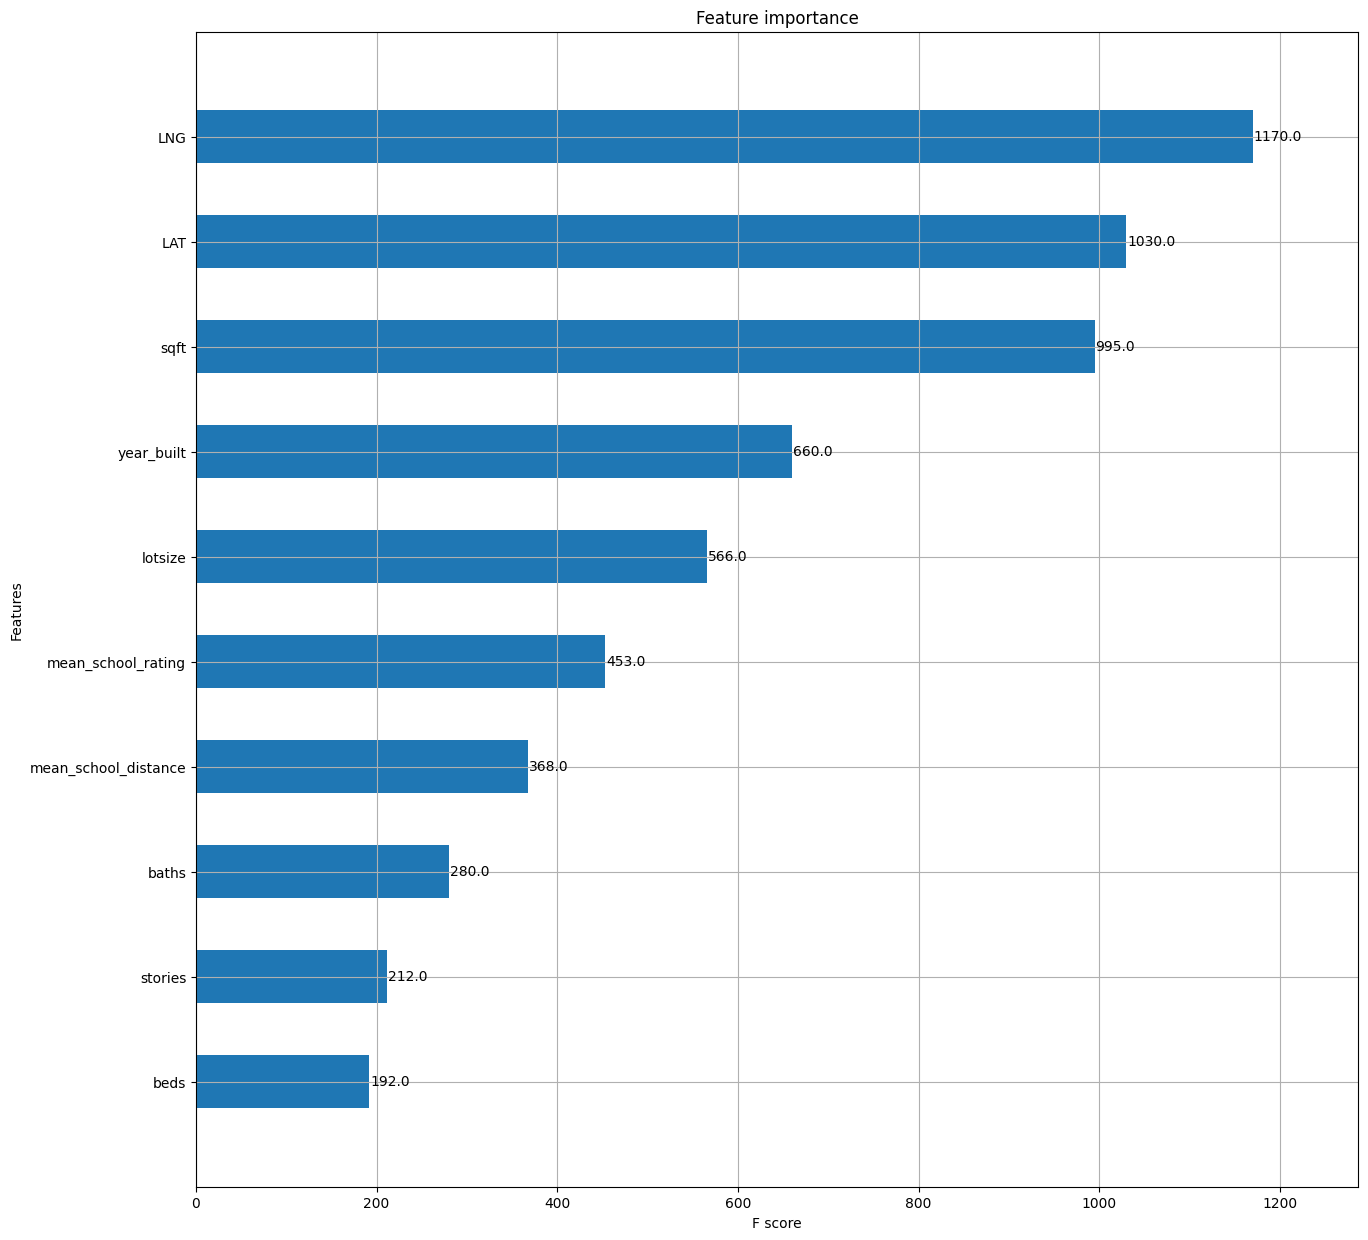

In [273]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(xgbmodel, ax = ax, height=0.5)

Если не смотреть на CatBoost и XGBoost, то лучшие результаты до этого показал градиентный бустинг над деревьями решений (GBDT) на 25 предикторах. Попробуем теперь обучить ее на лучших 10 предикторах, которые мы определили для CatBoost.

In [274]:
# градиентный бустинг

# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor(
    max_depth=10, #максимальная глубина дерева
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42, #генератор случайных чисел
    learning_rate=0.01 
)

# Обучаем модель
gb.fit(X_train_scal[new_best], y_train)

y_train_predict  = gb.predict(X_train_scal[new_best])
y_test_predict = gb.predict(X_test_scal[new_best])

s16 = print_metrics('GBDT top10', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.842
Train MAE: 101706.487
Train MAPE: 30.386%


Test R^2: 0.793
Test MAE: 110184.158
Test MAPE: 31.866%


Что интересно, одна и та же модель на 10 признаках отработала чуть лучше, чем на полном наборе.

Теперь попробуем **проапгрейдить модель стекинга.** Обучим её на наших 10 лучших предикторах, а в качестве базовых моделей возьмём 4 различных модели, которые мы ранее использовали:
- GradientBoostingRegressor;
- CatBoostRegressor;
- DecisionTreeRegressor;
- RidgeCV.

В качестве метамодели используем XGBoost. 

In [ ]:
# Создаем список базовых моделей
estimators = [
    ('gbdt', GradientBoostingRegressor(
                                            max_depth=10, #максимальная глубина дерева
                                            n_estimators=300, #количество деревьев в ансамбле
                                            random_state=42, #генератор случайных чисел
                                            learning_rate=0.01 )),
    ('cat',  CatBoostRegressor(random_state=42, verbose=False)), 
    ('dt', tree.DecisionTreeRegressor(random_state=42, max_depth=10)),
    ('r', RidgeCV())
]
# Создаем объект класса стекинг
reg = StackingRegressor(
    estimators=estimators, # Передаем список базовых моделей
    final_estimator=xgb.XGBRegressor()# В качестве метамодели используем xgb
)
# Обучаем модель
reg.fit(X_train_scal[new_best], y_train)

# Делаем предсказание классов с помощью метода predict(), а затем считаем метрики:
y_train_predict  = reg.predict(X_train_scal[new_best])
y_test_predict = reg.predict(X_test_scal[new_best])

s17 = print_metrics('Stacking GBDT+cat+dt+RidgeCV > xgb', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.865
Train MAE: 90486.163
Train MAPE: 23.715%


Test R^2: 0.824
Test MAE: 98063.891
Test MAPE: 24.947%


## Подбор гиперпараметров

Теперь оценим ряд моделей с подбором гипермараметров. Будем использовать:
+ GridSearchCV для DecisionTreeRegressor
+ RandomizedSearchCV для GradientBoostingRegressor
+ Optuna для XGBRegressor

#### GridSearchCV для DecisionTreeRegressor

In [289]:
param_grid = {'min_samples_leaf': list(np.linspace(1, 100, 50, dtype=int)),
              'max_depth': [9, 10]
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeRegressor(random_state=42), 
    param_grid=param_grid, 
    cv=5,
    n_jobs = -1
)  

grid_search_tree.fit(X_train_scal[best_features], y_train) 

y_train_predict = grid_search_tree.predict(X_train_scal[best_features])
y_test_predict = grid_search_tree.predict(X_test_scal[best_features])

s18 = print_metrics('DT+GridSearchCV', y_train, y_train_predict, y_test, y_test_predict)
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

Train R^2: 0.691
Train MAE: 142147.280
Train MAPE: 40.053%


Test R^2: 0.664
Test MAE: 144991.318
Test MAPE: 40.739%
Наилучшие значения гиперпараметров: {'max_depth': 10, 'min_samples_leaf': 15}


#### RandomizedSearchCV для GradientBoostingRegressor

In [290]:
param_distributions = {'n_estimators': [100, 200, 300],
              'learning_rate': [0.01, 0.05, 0.1]
              }
            
random_search_GB = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42, max_depth=10), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
random_search_GB.fit(X_train_scal[best_features], y_train) 

y_train_predict = random_search_GB.predict(X_train_scal[best_features])
y_test_predict = random_search_GB.predict(X_test_scal[best_features])

s19 = print_metrics('GBDT top10 + RandomizedSearchCV', y_train, y_train_predict, y_test, y_test_predict)
print("Наилучшие значения гиперпараметров: {}".format(random_search_GB.best_params_))

Train R^2: 0.943
Train MAE: 62527.234
Train MAPE: 17.365%


Test R^2: 0.855
Test MAE: 87131.990
Test MAPE: 21.706%
Наилучшие значения гиперпараметров: {'n_estimators': 300, 'learning_rate': 0.1}


На мой взгляд тут слишком большая разница у метрик на обучающем и тестовых наборов данных, что может свидетельствовать о переобучении

#### Optuna для XGBRegressor

In [ ]:
import optuna
# настроим оптимизацию гиперпараметров для алгоритма XGBoost
def optuna_xgb(trial):
    param = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.0),
        'max_depth': trial.suggest_int('max_depth', 8, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'random_state': trial.suggest_int('random_state', 42, 42)
    }
    model = xgb.XGBRegressor(**param)
    model.fit(X_train_scal[best_features], y_train)

    y_test_predict = model.predict(X_test_scal[best_features])

    test_mae = metrics.mean_absolute_error(y_test, y_test_predict)

    return test_mae

study = optuna.create_study(direction='minimize')
study.optimize(optuna_xgb, n_trials=100)

[I 2024-11-26 17:11:30,749] A new study created in memory with name: no-name-00514fd7-ab95-4225-8524-8b0f543b5f25
[I 2024-11-26 17:11:33,393] Trial 0 finished with value: 111457.54682742279 and parameters: {'learning_rate': 0.08451624219016639, 'max_depth': 8, 'subsample': 0.7687420290310003, 'colsample_bytree': 0.7675589481376379, 'random_state': 42}. Best is trial 0 with value: 111457.54682742279.
[I 2024-11-26 17:11:36,161] Trial 1 finished with value: 278697.38420617464 and parameters: {'learning_rate': 1.68830231937337e-05, 'max_depth': 8, 'subsample': 0.5472391532808112, 'colsample_bytree': 0.8388787883366982, 'random_state': 42}. Best is trial 0 with value: 111457.54682742279.
[I 2024-11-26 17:11:38,895] Trial 2 finished with value: 276295.16813964763 and parameters: {'learning_rate': 0.00016284264950936254, 'max_depth': 8, 'subsample': 0.6740049150896115, 'colsample_bytree': 0.7770226868431799, 'random_state': 42}. Best is trial 0 with value: 111457.54682742279.
[I 2024-11-26 1

{'learning_rate': 0.296780710199713, 'max_depth': 9, 'subsample': 0.9908350973743338, 'colsample_bytree': 0.9621822094768502, 'random_state': 42}


In [ ]:
# строим модель на лучших подобранных параметрах
param = study.best_params
xgbmodel = xgb.XGBRegressor(**param)
xgbmodel.fit(X_train_scal[new_best], y_train)
y_train_predict  = xgbmodel.predict(X_train_scal[new_best])
y_test_predict = xgbmodel.predict(X_test_scal[new_best])

s20 = print_metrics('XGBoost top10 + Optuna',y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.924
Train MAE: 70537.208
Train MAPE: 19.254%


Test R^2: 0.847
Test MAE: 90224.317
Test MAPE: 22.650%


# Оценка моделей

Создадим сводную таблицу по метрикам на обученных моделях.

In [293]:
res_df = pd.DataFrame(
    data = [s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12, s13, s14, s15, s16, s17, s18, s19, s20],
    columns= ['Model', 'Train R2', 'Train MAE', 'Train MAPE', 'Test R2', 'Test MAE', 'Test MAPE']
)
display(res_df)

Model  Train R2  Train MAE  Train MAPE  \
0                              LR full      0.42  207802.91       61.46   
1                             LR top25      0.38  215438.11       61.30   
2                             PR top25      0.52  186266.09       51.86   
3                             L1 Lasso      0.52  185977.25       51.61   
4                             L2 Ridge      0.52  186271.52       51.70   
5                             DT top25      1.00     777.16        0.19   
6                          DT depth-10      0.70  140856.47       39.89   
7                                  RFR      0.73  134204.26       38.82   
8                             AdaBoost      0.75  127111.55       37.10   
9                                 GBDT      0.83  106942.56       31.54   
10                            Stacking      0.70  140311.74       39.11   
11                      CatBoost top25      0.82  102839.49       26.17   
12                       CatBoost full      0.84   97670.03       24.70   
13                      CatBoost top10      0.83   99734.80       25.67   
14                       XGBoost top10      0.84   98900.46       25.55   
15                          GBDT top10      0.84  101706.49       30.39   
16  Stacking GBDT+cat+dt+RidgeCV > xgb      0.87   90486.16       23.72   
17                     DT+GridSearchCV      0.69  142147.28       40.05   
18     GBDT top10 + RandomizedSearchCV      0.94   62527.23       17.37   
19              XGBoost top10 + Optuna      0.92   70537.21       19.25   

    Test R2   Test MAE  Test MAPE  
0      0.42  207015.90      61.95  
1      0.37  214632.64      61.69  
2      0.51  186139.56      52.25  
3      0.51  185856.20      52.00  
4      0.51  186181.99      52.10  
5      0.70  106883.75      24.89  
6      0.66  144903.36      40.73  
7      0.70  137279.37      39.54  
8      0.72  132829.02      38.08  
9      0.78  114645.79      32.89  
10     0.67  144131.18      40.03  
11     0.80  105360.72      26.76  
12     0.82  100323.20      25.28  
13     0.81  102414.01      26.20  
14     0.81  104275.35      26.58  
15     0.79  110184.16      31.87  
16     0.82   98063.89      24.95  
17     0.66  144991.32      40.74  
18     0.86   87131.99      21.71  
19     0.85   90224.32      22.65

In [294]:
# Выгрузим результат в отдельный файл:
res_df.to_csv('data/models_results.csv', index = False)

**ИТАК:**
- Наилучший результат показал метод стекинга с набором базовых моделей, она показала среднюю абсолютную ошибку в **98** тыс. долларов или почти **25%**.
- На втором месте - CatBoost с ошибкой в **102** тыс. долларов или **26.2%**
- Ну и замыкает тройку лидеров XGBoost с ошибкой в **104** тыс. долларов или **26.6%**

**В итоге нам удалось повысить качество моделирования по сравнению с базовой моделью более чем в 2 раза.**

Две последние модели с подбором гиперпараметров дают неплохие результаты, но у них очень сильно разнятся показатели метрик на тренировочном и тестовом наборах данных, что может свидетельствовать о переобучении моделей и их подстройке под тренировочные данные.

Результаты конечно не слишком хорошие, средняя ошибка в 100 тыс долларов это существенная цифра - даже для дома стоимостью 1 млн. долларов это 10% от его стоимости.

Основная догадка почему получился такой "плохой" результат связана с тем, что в наших хоть и обработанных данных, но все-таки остались длинные "хвосты", например:
- для целевой переменной вправо - записи с ценой объекта свыше 1 млн. долларов;
- для признака года постройки влево - записи с годом постройки до 1900 года.

**Поэтому для проверки этой гипотезы были "отрезаны эти хвосты" и проведено исследование с использованием тех же самых моделей (см. файл **[diplom_branch2.ipynb](https://github.com/veshua/diplom_sf/blob/main/diplom_branch2.ipynb)**), результаты которого можем сравнить с текущими:**

In [295]:
# считываем таблицу результатов работы моделей на полных данных
res_df = pd.read_csv('data/models_results.csv') 
# считываем таблицу результатов работы моделей на "обрезанных" данных (из diplom_branch2.ipynb)
res_df_2 = pd.read_csv('data/models_results_short.csv') 
res_df = res_df.merge(
    res_df_2,
    on='Model',
    how='left'
)
res_df['dif_R2'] = res_df['Test R2_v2'] - res_df['Test R2']
res_df['dif_MAE'] = res_df['Test MAE_v2'] - res_df['Test MAE']
res_df['dif_MAPE'] = res_df['Test MAPE_v2'] - res_df['Test MAPE']
res_df[['Model', 
        'Test R2', 'Test MAE', 'Test MAPE', 
        'Test R2_v2', 'Test MAE_v2', 'Test MAPE_v2',
        'dif_R2', 'dif_MAE', 'dif_MAPE']]

Model  Test R2   Test MAE  Test MAPE  \
0                              LR full     0.42  207015.90      61.95   
1                             LR top25     0.37  214632.64      61.69   
2                             PR top25     0.51  186139.56      52.25   
3                             L1 Lasso     0.51  185856.20      52.00   
4                             L2 Ridge     0.51  186181.99      52.10   
5                             DT top25     0.70  106883.75      24.89   
6                          DT depth-10     0.66  144903.36      40.73   
7                                  RFR     0.70  137279.37      39.54   
8                             AdaBoost     0.72  132829.02      38.08   
9                                 GBDT     0.78  114645.79      32.89   
10                            Stacking     0.67  144131.18      40.03   
11                      CatBoost top25     0.80  105360.72      26.76   
12                       CatBoost full     0.82  100323.20      25.28   
13                      CatBoost top10     0.81  102414.01      26.20   
14                       XGBoost top10     0.81  104275.35      26.58   
15                          GBDT top10     0.79  110184.16      31.87   
16  Stacking GBDT+cat+dt+RidgeCV > xgb     0.82   98063.89      24.95   
17                     DT+GridSearchCV     0.66  144991.32      40.74   
18     GBDT top10 + RandomizedSearchCV     0.86   87131.99      21.71   
19              XGBoost top10 + Optuna     0.85   90224.32      22.65   

    Test R2_v2  Test MAE_v2  Test MAPE_v2  dif_R2   dif_MAE  dif_MAPE  
0         0.36    129000.52         49.06   -0.06 -78015.38    -12.89  
1         0.33    132291.73         50.61   -0.04 -82340.91    -11.08  
2         0.51    110858.57         39.86    0.00 -75280.99    -12.39  
3         0.51    110862.55         39.85    0.00 -74993.65    -12.15  
4         0.51    110989.12         39.91    0.00 -75192.87    -12.19  
5         0.69     67900.29         21.83   -0.01 -38983.46     -3.06  
6         0.65     90287.72         31.94   -0.01 -54615.64     -8.79  
7         0.69     85465.74         30.79   -0.01 -51813.63     -8.75  
8         0.68     86510.30         31.03   -0.04 -46318.72     -7.05  
9         0.79     69399.37         25.13    0.01 -45246.42     -7.76  
10        0.66     89925.11         31.96   -0.01 -54206.07     -8.07  
11        0.79     66945.59         22.29   -0.01 -38415.13     -4.47  
12        0.81     65037.30         21.66   -0.01 -35285.90     -3.62  
13        0.80     66840.64         22.67   -0.01 -35573.37     -3.53  
14        0.80     67128.55         22.75   -0.01 -37146.80     -3.83  
15        0.79     68075.81         25.01    0.00 -42108.35     -6.86  
16        0.82     61840.63         20.79    0.00 -36223.26     -4.16  
17        0.65     90056.30         31.89   -0.01 -54935.02     -8.85  
18        0.86     52776.61         17.37    0.00 -34355.38     -4.34  
19        0.85     54910.78         18.51    0.00 -35313.54     -4.14

+ Колонки без индекса v2 это наши метрики для соответствующих моделей на полных данных.
+ Колонки с индексом v2 это метрики для соответствующих моделей на "обрезанных" данных (результаты моделирования из [diplom_branch2.ipynb](https://github.com/veshua/diplom_sf/blob/main/diplom_branch2.ipynb))
+ Колонки с префиксом dif содержат разницу метрик между двумя наборами данных.

Какие можно сделать выводы из этой таблицы:
- коэффициент детерминации R2 с увеличением сложности модели выравнивается (на базовых моделях он хуже на обрезанных данных);
- с повышением сложности моделей разница в показателе средней абослютной ошибки постепенно уменьшается;
- тот же самый вывод можно сделать и для показателя средней относительной ошибки - чем сложнее модель, тем меньше набор данных влияет на качество моделей.

**Таким образом, избавление от записей-выбросов со стоимостью более 1 млн.долларов и годом постройки ранее 1900 года позволили нам снизить показатель абсолютной ошибки примерно на 36 тыс. долларов (62-67 в отличии от 98-104), а показатель относительной ошибки на 4% (20.7-22.7 в отличии от 25-26.5)**

### Топ-10 предикторов для использования в модели

Как оговорено выше для нашей продакшн модели будут использоваться следующие 10 предикторов:
- **LNG** - географическая долгота объекта;
- **sqft** - площадь дома в квадратных футах;
- **LAT** - географическая широта объекта;
- **year_built** - год постройки дома;
- **mean_school_rating** - средний рейтинг школ поблизости;
- **baths** — количество ванных комнат;
- **stories** — количество этажей в доме;
- **lotsize** — площадь придомового участка в квадратных футах;
- **beds** — количество спален в доме;
- **mean_school_distance** - среднее расстояние до школ поблизости.

# Внедрение в продакшн

Для продакшн модели будем использовать - CatBoost.\
Несмотря на то, что она находится на 2м месте по показателям MAE и MAPE, но по сравнению с лидером она в разы быстрее работает и сериализованная модель занимает не много места.

In [296]:
# зафиксируем окружение
!pip freeze > requirements.txt

In [297]:
# Приведем наши тренировочные датасеты в массивы (без заголовков столбцов), т.к. по Flask будет подаваться 
# массив данных для предсказания, заголовки будут выдавать ошибку
X_train_scal = X_train_scal[new_best].values
y_train = y_train.values

# Инициализируем и обучим модель
catmodel = CatBoostRegressor(random_state=42, verbose=False)
catmodel.fit(X_train_scal, y_train)

# Сериализуем и запишем результат в файл
with open('cat_model.pkl', 'wb') as output:
    pickle.dump(catmodel, output)

# Заключение

Для работы были использованы реальные данные об объектах недвижимости. Заполнены они как попало, поэтому данные очень грязные и на их очистку было потрачена значительная часть времени, отведенная на дипломный проект. Работа была долгой и кропотливой. Старался сохранить как можно больше данных, поэтому не особо пользовался удалением записей на основе пропусков в тех или иных признаках, а старался заполнять их известными методами.

В итоге, по результатам очистки было сохранено 79% от объема первоначальных данных. Далее проведен краткий разведывательный анализ данных, модифицированы категориальные переменные.

На этапе моделирования были построены 20 различных моделей для решения нашей задачи регрессии, от простых к сложным. Постепенно наши метрики улучшались и по итогу удалось повысить качество моделирования по сравнению с базовой моделью более чем в 2 раза! Несмотря на это, результаты на мой взгляд не выдающиеся, показатель средней абсолютной ошибки достаточно высокий.

Как говорится хорошая мысля приходит опосля и перед сдачей проекта пришли идеи как еще можно было бы улучшить результаты:
1. Вернутся и более качественно подойти к этапу очистки и моделирования данных для наших ТОП-10 предикторов.
2. Попробовать создать новые признаки,  например, по географическим координатам подтянуть близость к центрам городов или близость к аэропортам, т.к. данная информация может влиять на стоимость недвижимости. 
3. Сделать заполнение пропусков не с помощью медиан или средних, а используя ML, например модели кластеризации.
4. Пробовать более тонкую настройку моделей через подбор гипермараметров, но для этого нужны бОльшие вычислительные ресурсы, т.к. на моем компе, например, RandomizedSearchCV для GradientBoostingRegressor отрабатывал более 1,5 часов.
5. Для избавления от выбросов использовать такие методы ка: Isolation Forest, Local Outlier Factor, Minimum Covariance Determinant.
6. Для нормализации признаков использовать такие методы как: QUANTILE TRANSFORMER, LOG TRANSFORM, POWER TRANSFORMER SCALER

Но, учту уже это в следующих задачах ))